In [3]:
# Core libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import warnings
warnings.filterwarnings("ignore")



## Data path

In [6]:
data_path=r"../data/dataset"
img_size=(150,150)

## Class names and it's indices

In [9]:
class_names = sorted(os.listdir(data_path))
class_indices = {name: i for i, name in enumerate(class_names)}  
print(f"Class names: {class_names}")
print(f"Class indices: {class_indices}")

Class names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Class indices: {'dew': 0, 'fogsmog': 1, 'frost': 2, 'glaze': 3, 'hail': 4, 'lightning': 5, 'rain': 6, 'rainbow': 7, 'rime': 8, 'sandstorm': 9, 'snow': 10}


## Load images

In [12]:
train_data = []  # List to store images
train_labels = []  # List to store labels

# Get the class names from the folder names
class_names = sorted(os.listdir(data_path))  
class_indices = {name: i for i, name in enumerate(class_names)}  # Mapping class names to indices

# Load images and their corresponding labels
# load the class
for class_name in class_names:
    class_folder = os.path.join(data_path, class_name)  # Path to the current class folder
    if not os.path.isdir(class_folder):  # Skip if it's not a folder
        continue
        #load the image
    for file in os.listdir(class_folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check if the file is an image
            img_path = os.path.join(class_folder, file)  # Path to the image
            img = cv2.imread(img_path)  # Read the image using OpenCV
            if img is not None:
                img = cv2.resize(img, img_size)  # Resize the image to the specified size
                img = img.astype('float32') / 255.0  # Normalize the image (scale pixel values between 0 and 1)
                train_data.append(img)  # Add the image to the training data
                train_labels.append(class_indices[class_name])  # Add the label to the training labels


In [13]:
# Convert lists to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

## Split data to train and test

In [15]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels)


In [16]:
# one hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define model
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),  # fixed for now
        Dense(64, activation='relu'),  # fixed for now
        Dropout(0.2),  # fixed for now
        Dense(11, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),  # fixed for now
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Wrap model
model = KerasClassifier(model=create_model, verbose=0)

# ✅ Grid for batch size and epochs only
param_grid = {
    "batch_size": [16, 32, 64],
    "epochs": [5, 10]
}

# Grid Search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=2,          # (you can use 2 folds for faster testing)
    verbose=2
)

# Fit the model
grid_result = grid.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Accuracy:", grid_result.best_score_)


Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ............................batch_size=16, epochs=5; total time=  58.6s
[CV] END ............................batch_size=16, epochs=5; total time= 1.2min
[CV] END ...........................batch_size=16, epochs=10; total time= 1.8min
[CV] END ...........................batch_size=16, epochs=10; total time= 2.5min
[CV] END ............................batch_size=32, epochs=5; total time= 1.0min
[CV] END ............................batch_size=32, epochs=5; total time= 1.1min
[CV] END ...........................batch_size=32, epochs=10; total time= 1.7min
[CV] END ...........................batch_size=32, epochs=10; total time= 2.3min
[CV] END ............................batch_size=64, epochs=5; total time= 1.1min
[CV] END ............................batch_size=64, epochs=5; total time= 1.0min
[CV] END ...........................batch_size=64, epochs=10; total time= 1.7min
[CV] END ...........................batch_size=64

In [18]:
best_batch_size = 64
best_epochs = 10

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# 1. Define the model
def create_model(dropout1=0.4, dropout2=0.3, dense_units=64, learning_rate=0.001):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(dropout1),
        Dense(dense_units, activation='relu'),
        Dropout(dropout2),
        Dense(11, activation='softmax')  # make sure you have 11 classes
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Correct KerasClassifier wrapper
model = KerasClassifier(
    model=create_model,    # use model= not build_fn=
    verbose=0,
    batch_size=best_batch_size,
    epochs=best_epochs
)

# 3. Define param grid (correct model__ names)
param_grid = {
    "model__dropout1": [0.3, 0.4],
    "model__dropout2": [0.2, 0.3],
    "model__dense_units": [64, 128],
    "model__learning_rate": [0.001, 0.0001]
}

# 4. Set up GridSearchCV
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=2
)

# 5. Fit the model
grid_result = grid.fit(X_train, y_train)

# 6. Output the results
print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Accuracy:", grid_result.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.2, model__learning_rate=0.001; total time= 2.0min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.2, model__learning_rate=0.001; total time= 2.0min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.2, model__learning_rate=0.001; total time= 2.1min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.2, model__learning_rate=0.0001; total time= 2.0min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.2, model__learning_rate=0.0001; total time= 2.0min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.2, model__learning_rate=0.0001; total time= 2.1min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.3, model__learning_rate=0.001; total time= 2.0min
[CV] END model__dense_units=64, model__dropout1=0.3, model__dropout2=0.3, model__learning

In [20]:
best_dense_units= 128
best_dropput1 =  0.3
best_dropput2 =  0.2
best_model__learning_rate = 0.001

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

# ── Your best‐found hyperparameters ─────────────────────────────
best_batch_size      = 64
best_epochs          = 10
best_dense_units     = 128
best_dropout1        = 0.3
best_dropout2        = 0.2
best_learning_rate   = 0.001
# ────────────────────────────────────────────────────────────────

def create_model(activation='relu'):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(best_dropout1),                         # fixed
        Dense(best_dense_units, activation=activation), # tunable
        Dropout(best_dropout2),                         # fixed
        Dense(11, activation='softmax')                 # your 11 classes
    ])

    model.compile(
        optimizer=Adam(learning_rate=best_learning_rate), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Wrap it for sklearn
clf = KerasClassifier(
    model=create_model,
    batch_size=best_batch_size,
    epochs=best_epochs,
    verbose=0
)

# Only search over activation functions
param_grid = {
    "model__activation": ["relu", "tanh", "sigmoid"]
}

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    verbose=2
)

# Run it!
grid_result = grid.fit(X_train, y_train)

print("Best Activation:", grid_result.best_params_["model__activation"])
print("Best CV Accuracy:", grid_result.best_score_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END .............................model__activation=relu; total time= 2.1min
[CV] END .............................model__activation=relu; total time= 2.0min
[CV] END .............................model__activation=relu; total time= 2.0min
[CV] END .............................model__activation=tanh; total time= 2.0min
[CV] END .............................model__activation=tanh; total time= 2.0min
[CV] END .............................model__activation=tanh; total time= 2.1min
[CV] END ..........................model__activation=sigmoid; total time= 2.4min
[CV] END ..........................model__activation=sigmoid; total time= 2.3min
[CV] END ..........................model__activation=sigmoid; total time= 2.2min
Best Activation: sigmoid
Best CV Accuracy: 0.8194228584005314


In [22]:
best_activation = 'sigmoid'

In [23]:
print(f"Train images shape: {X_train.shape}")
print(f"Test images shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train images shape: (5488, 150, 150, 3)
Test images shape: (1372, 150, 150, 3)
Train labels shape: (5488, 11)
Test labels shape: (1372, 11)


## Print images in plot

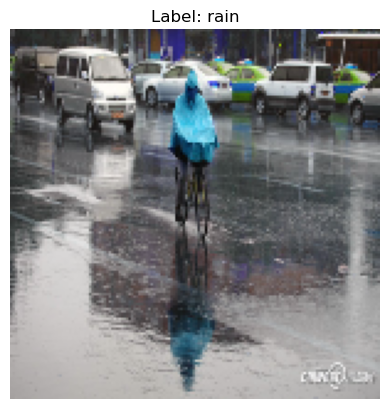

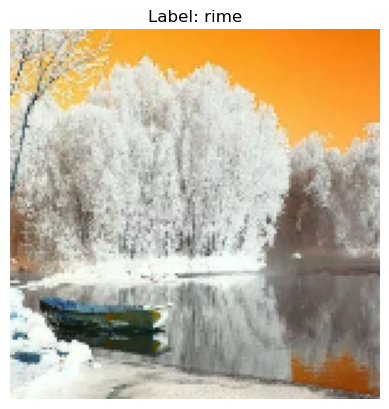

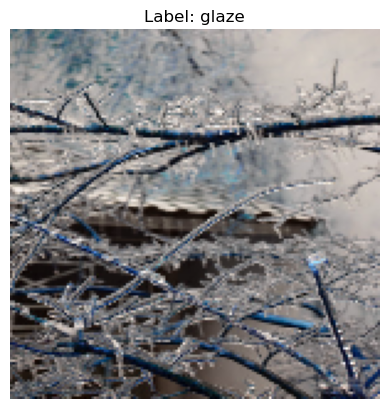

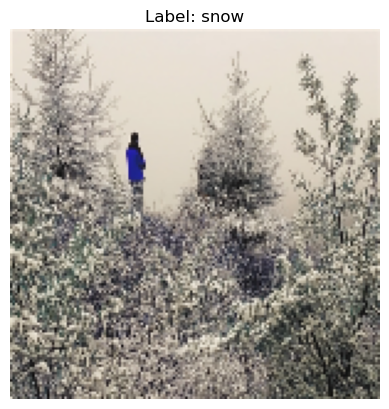

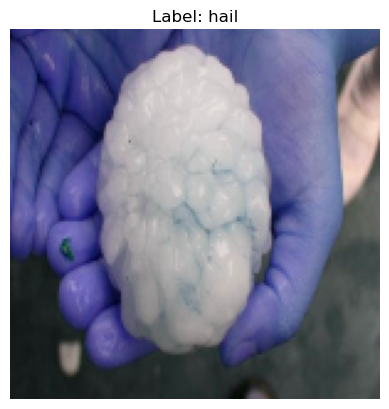

In [25]:
for i in range(5):  
    img = X_train[i]
    label = y_train[i]

    # Get the index of the label from one-hot encoding
    class_index = np.argmax(label)  # Get class index from one-hot
    class_name = class_names[class_index]  # Get the class name

    plt.imshow(img)
    plt.title(f"Label: {class_name}")
    plt.axis('off')
    plt.show()

## Neural network model

In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# no update for weights of the base model
base_model.trainable = False

# define the model using best parameters from Grid Search
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(best_dropput1),  # 0.3 from GridSearch
    Dense(best_dense_units, activation=best_activation),  # 128 from GridSearch
    Dropout(best_dropput2),  # 0.2 from GridSearch
    Dense(11, activation='softmax')  # assuming 11 classes
])




 # Model Compilation

In [29]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=best_model__learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model

In [31]:
history = model.fit(
    X_train,
    y_train,
    epochs=best_epochs,
    batch_size=best_batch_size
)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.4659 - loss: 1.6357
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.7582 - loss: 0.7482
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - accuracy: 0.8026 - loss: 0.6019
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8130 - loss: 0.5407
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.8316 - loss: 0.5116
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8393 - loss: 0.4762
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.8509 - loss: 0.4230
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8678 - loss: 0.4002
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8647 - loss: 0.3957
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 201ms/step - accuracy: 0.8770 - loss: 0.3728


# Model evaluation

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))



Test Accuracy: 82.00%


In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\kokya\Documents\neural network\weather classification\task_neural\data\prediction\th.jpeg"

img = image.load_img(img_path, target_size=(150, 150))

img_array = image.img_to_array(img)

# توسيع البُعد ليصبح (1, 150, 150, 3)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)


predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicted class: [5]


In [41]:
from tensorflow.keras.preprocessing import image
import numpy as np


img_path = r"C:\Users\kokya\Documents\neural network\weather classification\task_neural\data\prediction\th (1).jpeg"


img = image.load_img(img_path, target_size=(150, 150))


img_array = image.img_to_array(img)

# توسيع البُعد ليصبح (1, 150, 150, 3)
img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0


predictions = model.predict(img_array)


predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: [8]


In [43]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"C:\Users\kokya\Documents\neural network\weather classification\task_neural\data\prediction\rainbow.jpg"

img = image.load_img(img_path, target_size=(150, 150))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: [7]


In [45]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"../data/prediction/th.jpeg"

img = image.load_img(img_path, target_size=(150, 150))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted class: [5]


In [49]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = r"../data/prediction/th (1).jpeg"

img = image.load_img(img_path, target_size=(150, 150))

img_array = image.img_to_array(img)

img_array = np.expand_dims(img_array, axis=0)

img_array /= 255.0

predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: [8]
